In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [20]:
# Root directory for dataset 실제 이미지 루트는 data/celeba안에 있지만 그전까지만 지정해준다
# https://github.com/pytorch/examples/issues/236 참고하기
dataroot = "data/image"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 80000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

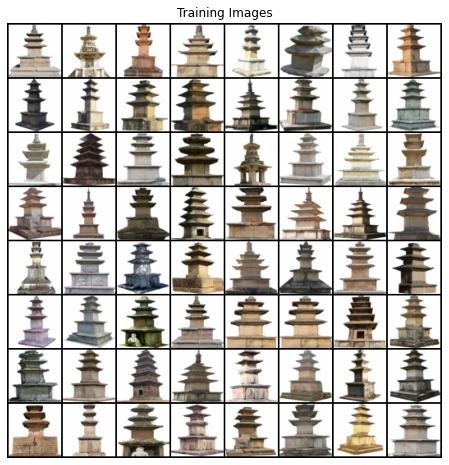

In [6]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/80000][0/2]	Loss_D: 0.2098	Loss_G: 7.0758	D(x): 0.9402	D(G(z)): 0.1210 / 0.0015
[1/80000][0/2]	Loss_D: 0.5886	Loss_G: 11.2822	D(x): 0.9417	D(G(z)): 0.3784 / 0.0000
[2/80000][0/2]	Loss_D: 0.9017	Loss_G: 11.2749	D(x): 0.9925	D(G(z)): 0.5268 / 0.0001
[3/80000][0/2]	Loss_D: 0.1807	Loss_G: 3.9127	D(x): 0.9175	D(G(z)): 0.0776 / 0.0299
[4/80000][0/2]	Loss_D: 1.6592	Loss_G: 5.9129	D(x): 0.3007	D(G(z)): 0.0003 / 0.0061
[5/80000][0/2]	Loss_D: 0.6146	Loss_G: 11.4084	D(x): 0.9961	D(G(z)): 0.4148 / 0.0000
[6/80000][0/2]	Loss_D: 0.0730	Loss_G: 4.6768	D(x): 0.9516	D(G(z)): 0.0187 / 0.0241
[7/80000][0/2]	Loss_D: 0.1034	Loss_G: 5.9494	D(x): 0.9431	D(G(z)): 0.0386 / 0.0041
[8/80000][0/2]	Loss_D: 0.1695	Loss_G: 4.5001	D(x): 0.9291	D(G(z)): 0.0841 / 0.0151
[9/80000][0/2]	Loss_D: 0.2142	Loss_G: 4.6536	D(x): 0.9081	D(G(z)): 0.0995 / 0.0136
[10/80000][0/2]	Loss_D: 0.2528	Loss_G: 4.6810	D(x): 0.8836	D(G(z)): 0.0977 / 0.0175
[11/80000][0/2]	Loss_D: 0.2692	Loss_G: 4.3529	D(x): 0.847

[98/80000][0/2]	Loss_D: 0.1789	Loss_G: 4.5899	D(x): 0.9546	D(G(z)): 0.1173 / 0.0156
[99/80000][0/2]	Loss_D: 0.2018	Loss_G: 4.7430	D(x): 0.9683	D(G(z)): 0.1482 / 0.0122
[100/80000][0/2]	Loss_D: 0.1835	Loss_G: 4.3853	D(x): 0.9519	D(G(z)): 0.1190 / 0.0172
[101/80000][0/2]	Loss_D: 0.1300	Loss_G: 3.7297	D(x): 0.9364	D(G(z)): 0.0579 / 0.0321
[102/80000][0/2]	Loss_D: 0.1757	Loss_G: 4.9695	D(x): 0.9614	D(G(z)): 0.1222 / 0.0099
[103/80000][0/2]	Loss_D: 0.8616	Loss_G: 10.3646	D(x): 0.9920	D(G(z)): 0.5238 / 0.0001
[104/80000][0/2]	Loss_D: 0.0972	Loss_G: 3.2272	D(x): 0.9865	D(G(z)): 0.0754 / 0.0673
[105/80000][0/2]	Loss_D: 0.2180	Loss_G: 4.8375	D(x): 0.8671	D(G(z)): 0.0481 / 0.0156
[106/80000][0/2]	Loss_D: 0.6243	Loss_G: 8.9451	D(x): 0.9179	D(G(z)): 0.3812 / 0.0005
[107/80000][0/2]	Loss_D: 2.3045	Loss_G: 12.1669	D(x): 0.9992	D(G(z)): 0.8497 / 0.0004
[108/80000][0/2]	Loss_D: 0.2797	Loss_G: 3.4175	D(x): 0.9750	D(G(z)): 0.1677 / 0.0774
[109/80000][0/2]	Loss_D: 0.7270	Loss_G: 5.3870	D(x): 0.6288	D(G(z

[195/80000][0/2]	Loss_D: 0.4582	Loss_G: 2.3649	D(x): 0.9431	D(G(z)): 0.2622 / 0.1559
[196/80000][0/2]	Loss_D: 1.1782	Loss_G: 0.6706	D(x): 0.4288	D(G(z)): 0.0247 / 0.5784
[197/80000][0/2]	Loss_D: 0.5162	Loss_G: 5.9407	D(x): 0.6782	D(G(z)): 0.0121 / 0.0079
[198/80000][0/2]	Loss_D: 0.7866	Loss_G: 6.2084	D(x): 0.9831	D(G(z)): 0.4649 / 0.0033
[199/80000][0/2]	Loss_D: 0.2599	Loss_G: 2.6955	D(x): 0.8667	D(G(z)): 0.0952 / 0.0944
[200/80000][0/2]	Loss_D: 0.3316	Loss_G: 3.3080	D(x): 0.7910	D(G(z)): 0.0685 / 0.0507
[201/80000][0/2]	Loss_D: 0.2545	Loss_G: 4.5110	D(x): 0.9318	D(G(z)): 0.1531 / 0.0157
[202/80000][0/2]	Loss_D: 0.3278	Loss_G: 4.6987	D(x): 0.9498	D(G(z)): 0.2244 / 0.0128
[203/80000][0/2]	Loss_D: 0.2926	Loss_G: 4.3887	D(x): 0.9558	D(G(z)): 0.2015 / 0.0185
[204/80000][0/2]	Loss_D: 0.2149	Loss_G: 4.0435	D(x): 0.9563	D(G(z)): 0.1486 / 0.0244
[205/80000][0/2]	Loss_D: 0.1553	Loss_G: 3.4931	D(x): 0.9036	D(G(z)): 0.0494 / 0.0432
[206/80000][0/2]	Loss_D: 0.2007	Loss_G: 4.2647	D(x): 0.9412	D(G(z

[292/80000][0/2]	Loss_D: 0.1716	Loss_G: 3.2052	D(x): 0.9146	D(G(z)): 0.0761 / 0.0536
[293/80000][0/2]	Loss_D: 0.1647	Loss_G: 3.7445	D(x): 0.9304	D(G(z)): 0.0851 / 0.0303
[294/80000][0/2]	Loss_D: 0.1658	Loss_G: 3.2245	D(x): 0.9085	D(G(z)): 0.0643 / 0.0535
[295/80000][0/2]	Loss_D: 0.1641	Loss_G: 3.6853	D(x): 0.9224	D(G(z)): 0.0763 / 0.0340
[296/80000][0/2]	Loss_D: 0.1628	Loss_G: 3.8482	D(x): 0.9476	D(G(z)): 0.0972 / 0.0296
[297/80000][0/2]	Loss_D: 0.1661	Loss_G: 3.4315	D(x): 0.9257	D(G(z)): 0.0815 / 0.0418
[298/80000][0/2]	Loss_D: 0.1365	Loss_G: 3.5382	D(x): 0.9331	D(G(z)): 0.0629 / 0.0378
[299/80000][0/2]	Loss_D: 0.1367	Loss_G: 3.4904	D(x): 0.9288	D(G(z)): 0.0589 / 0.0396
[300/80000][0/2]	Loss_D: 0.1408	Loss_G: 3.5858	D(x): 0.9347	D(G(z)): 0.0689 / 0.0349
[301/80000][0/2]	Loss_D: 0.1513	Loss_G: 3.9973	D(x): 0.9541	D(G(z)): 0.0952 / 0.0241
[302/80000][0/2]	Loss_D: 0.1676	Loss_G: 4.0707	D(x): 0.9665	D(G(z)): 0.1217 / 0.0214
[303/80000][0/2]	Loss_D: 0.1173	Loss_G: 3.2137	D(x): 0.9236	D(G(z

[389/80000][0/2]	Loss_D: 0.1108	Loss_G: 3.0177	D(x): 0.9188	D(G(z)): 0.0247 / 0.0650
[390/80000][0/2]	Loss_D: 0.1092	Loss_G: 3.4511	D(x): 0.9216	D(G(z)): 0.0261 / 0.0437
[391/80000][0/2]	Loss_D: 0.1117	Loss_G: 4.5333	D(x): 0.9744	D(G(z)): 0.0801 / 0.0149
[392/80000][0/2]	Loss_D: 0.1381	Loss_G: 4.3802	D(x): 0.9791	D(G(z)): 0.1063 / 0.0163
[393/80000][0/2]	Loss_D: 0.1110	Loss_G: 3.8742	D(x): 0.9647	D(G(z)): 0.0703 / 0.0272
[394/80000][0/2]	Loss_D: 0.0900	Loss_G: 3.7465	D(x): 0.9654	D(G(z)): 0.0524 / 0.0294
[395/80000][0/2]	Loss_D: 0.1022	Loss_G: 4.0016	D(x): 0.9601	D(G(z)): 0.0579 / 0.0258
[396/80000][0/2]	Loss_D: 0.0976	Loss_G: 4.0456	D(x): 0.9724	D(G(z)): 0.0656 / 0.0244
[397/80000][0/2]	Loss_D: 0.1091	Loss_G: 4.2375	D(x): 0.9713	D(G(z)): 0.0739 / 0.0199
[398/80000][0/2]	Loss_D: 0.0987	Loss_G: 4.1038	D(x): 0.9779	D(G(z)): 0.0717 / 0.0215
[399/80000][0/2]	Loss_D: 0.1225	Loss_G: 4.4974	D(x): 0.9767	D(G(z)): 0.0917 / 0.0146
[400/80000][0/2]	Loss_D: 0.1102	Loss_G: 3.9897	D(x): 0.9692	D(G(z

[486/80000][0/2]	Loss_D: 0.1218	Loss_G: 3.4480	D(x): 0.9601	D(G(z)): 0.0758 / 0.0404
[487/80000][0/2]	Loss_D: 0.0969	Loss_G: 3.8861	D(x): 0.9419	D(G(z)): 0.0355 / 0.0271
[488/80000][0/2]	Loss_D: 0.1199	Loss_G: 4.2343	D(x): 0.9707	D(G(z)): 0.0838 / 0.0185
[489/80000][0/2]	Loss_D: 0.1299	Loss_G: 3.9569	D(x): 0.9723	D(G(z)): 0.0943 / 0.0246
[490/80000][0/2]	Loss_D: 0.1164	Loss_G: 3.1873	D(x): 0.9159	D(G(z)): 0.0270 / 0.0571
[491/80000][0/2]	Loss_D: 0.1072	Loss_G: 3.9708	D(x): 0.9450	D(G(z)): 0.0480 / 0.0258
[492/80000][0/2]	Loss_D: 0.0981	Loss_G: 3.6242	D(x): 0.9523	D(G(z)): 0.0466 / 0.0350
[493/80000][0/2]	Loss_D: 0.1003	Loss_G: 3.6508	D(x): 0.9497	D(G(z)): 0.0465 / 0.0323
[494/80000][0/2]	Loss_D: 0.0942	Loss_G: 3.8956	D(x): 0.9631	D(G(z)): 0.0541 / 0.0260
[495/80000][0/2]	Loss_D: 0.1609	Loss_G: 4.8930	D(x): 0.9738	D(G(z)): 0.1200 / 0.0100
[496/80000][0/2]	Loss_D: 0.3295	Loss_G: 5.2368	D(x): 0.9923	D(G(z)): 0.2609 / 0.0068
[497/80000][0/2]	Loss_D: 0.0857	Loss_G: 3.5100	D(x): 0.9709	D(G(z

[583/80000][0/2]	Loss_D: 0.1302	Loss_G: 4.2907	D(x): 0.9901	D(G(z)): 0.1083 / 0.0172
[584/80000][0/2]	Loss_D: 0.0912	Loss_G: 3.4362	D(x): 0.9301	D(G(z)): 0.0171 / 0.0421
[585/80000][0/2]	Loss_D: 0.0484	Loss_G: 4.9573	D(x): 0.9813	D(G(z)): 0.0287 / 0.0091
[586/80000][0/2]	Loss_D: 0.0571	Loss_G: 4.1806	D(x): 0.9863	D(G(z)): 0.0417 / 0.0202
[587/80000][0/2]	Loss_D: 0.0779	Loss_G: 3.0823	D(x): 0.9366	D(G(z)): 0.0119 / 0.0651
[588/80000][0/2]	Loss_D: 0.0584	Loss_G: 4.2258	D(x): 0.9564	D(G(z)): 0.0134 / 0.0195
[589/80000][0/2]	Loss_D: 0.0452	Loss_G: 4.2944	D(x): 0.9708	D(G(z)): 0.0153 / 0.0188
[590/80000][0/2]	Loss_D: 0.0544	Loss_G: 4.9416	D(x): 0.9857	D(G(z)): 0.0385 / 0.0099
[591/80000][0/2]	Loss_D: 0.2212	Loss_G: 6.6746	D(x): 0.9962	D(G(z)): 0.1876 / 0.0019
[592/80000][0/2]	Loss_D: 0.4540	Loss_G: 8.4878	D(x): 0.9953	D(G(z)): 0.3087 / 0.0004
[593/80000][0/2]	Loss_D: 1.1008	Loss_G: 15.7250	D(x): 0.9905	D(G(z)): 0.5843 / 0.0000
[594/80000][0/2]	Loss_D: 1.3392	Loss_G: 4.4850	D(x): 0.9045	D(G(

[680/80000][0/2]	Loss_D: 0.4713	Loss_G: 3.4796	D(x): 0.7077	D(G(z)): 0.0610 / 0.0459
[681/80000][0/2]	Loss_D: 0.3205	Loss_G: 4.0198	D(x): 0.8457	D(G(z)): 0.1257 / 0.0240
[682/80000][0/2]	Loss_D: 0.3034	Loss_G: 3.9955	D(x): 0.8654	D(G(z)): 0.1307 / 0.0273
[683/80000][0/2]	Loss_D: 0.2245	Loss_G: 3.4953	D(x): 0.8655	D(G(z)): 0.0715 / 0.0400
[684/80000][0/2]	Loss_D: 0.4524	Loss_G: 1.4139	D(x): 0.6748	D(G(z)): 0.0230 / 0.2949
[685/80000][0/2]	Loss_D: 0.7791	Loss_G: 5.2730	D(x): 0.5632	D(G(z)): 0.0056 / 0.0145
[686/80000][0/2]	Loss_D: 0.4016	Loss_G: 5.9261	D(x): 0.9880	D(G(z)): 0.2900 / 0.0043
[687/80000][0/2]	Loss_D: 0.2097	Loss_G: 3.2068	D(x): 0.8850	D(G(z)): 0.0760 / 0.0532
[688/80000][0/2]	Loss_D: 0.3073	Loss_G: 3.3342	D(x): 0.7983	D(G(z)): 0.0493 / 0.0507
[689/80000][0/2]	Loss_D: 0.1645	Loss_G: 4.4758	D(x): 0.9157	D(G(z)): 0.0698 / 0.0153
[690/80000][0/2]	Loss_D: 0.1965	Loss_G: 4.0678	D(x): 0.9396	D(G(z)): 0.1207 / 0.0213
[691/80000][0/2]	Loss_D: 0.1695	Loss_G: 3.7036	D(x): 0.9021	D(G(z

[777/80000][0/2]	Loss_D: 0.0530	Loss_G: 4.7617	D(x): 0.9823	D(G(z)): 0.0342 / 0.0106
[778/80000][0/2]	Loss_D: 0.0549	Loss_G: 4.3042	D(x): 0.9903	D(G(z)): 0.0435 / 0.0164
[779/80000][0/2]	Loss_D: 0.0445	Loss_G: 4.3737	D(x): 0.9781	D(G(z)): 0.0219 / 0.0159
[780/80000][0/2]	Loss_D: 0.0408	Loss_G: 4.2818	D(x): 0.9807	D(G(z)): 0.0209 / 0.0181
[781/80000][0/2]	Loss_D: 0.0466	Loss_G: 4.1777	D(x): 0.9741	D(G(z)): 0.0199 / 0.0206
[782/80000][0/2]	Loss_D: 0.0471	Loss_G: 4.5150	D(x): 0.9812	D(G(z)): 0.0273 / 0.0150
[783/80000][0/2]	Loss_D: 0.0463	Loss_G: 4.1974	D(x): 0.9815	D(G(z)): 0.0270 / 0.0188
[784/80000][0/2]	Loss_D: 0.0510	Loss_G: 4.1210	D(x): 0.9724	D(G(z)): 0.0225 / 0.0210
[785/80000][0/2]	Loss_D: 0.0445	Loss_G: 3.8843	D(x): 0.9711	D(G(z)): 0.0149 / 0.0263
[786/80000][0/2]	Loss_D: 0.0683	Loss_G: 3.1636	D(x): 0.9420	D(G(z)): 0.0081 / 0.0557
[787/80000][0/2]	Loss_D: 0.0501	Loss_G: 4.8044	D(x): 0.9644	D(G(z)): 0.0134 / 0.0118
[788/80000][0/2]	Loss_D: 0.0687	Loss_G: 4.4799	D(x): 0.9871	D(G(z

[874/80000][0/2]	Loss_D: 0.0620	Loss_G: 4.0178	D(x): 0.9680	D(G(z)): 0.0287 / 0.0238
[875/80000][0/2]	Loss_D: 0.0537	Loss_G: 4.2515	D(x): 0.9740	D(G(z)): 0.0267 / 0.0173
[876/80000][0/2]	Loss_D: 0.0666	Loss_G: 4.3928	D(x): 0.9847	D(G(z)): 0.0493 / 0.0151
[877/80000][0/2]	Loss_D: 0.0554	Loss_G: 4.1846	D(x): 0.9799	D(G(z)): 0.0342 / 0.0186
[878/80000][0/2]	Loss_D: 0.0567	Loss_G: 4.1773	D(x): 0.9735	D(G(z)): 0.0290 / 0.0191
[879/80000][0/2]	Loss_D: 0.0567	Loss_G: 4.2850	D(x): 0.9765	D(G(z)): 0.0319 / 0.0182
[880/80000][0/2]	Loss_D: 0.0622	Loss_G: 4.1032	D(x): 0.9693	D(G(z)): 0.0301 / 0.0218
[881/80000][0/2]	Loss_D: 0.0507	Loss_G: 4.0429	D(x): 0.9714	D(G(z)): 0.0213 / 0.0217
[882/80000][0/2]	Loss_D: 0.0521	Loss_G: 4.3689	D(x): 0.9761	D(G(z)): 0.0272 / 0.0163
[883/80000][0/2]	Loss_D: 0.0550	Loss_G: 4.2385	D(x): 0.9756	D(G(z)): 0.0295 / 0.0182
[884/80000][0/2]	Loss_D: 0.0480	Loss_G: 4.0968	D(x): 0.9718	D(G(z)): 0.0190 / 0.0211
[885/80000][0/2]	Loss_D: 0.0523	Loss_G: 4.2434	D(x): 0.9707	D(G(z

[971/80000][0/2]	Loss_D: 0.0620	Loss_G: 4.2147	D(x): 0.9681	D(G(z)): 0.0289 / 0.0184
[972/80000][0/2]	Loss_D: 0.0690	Loss_G: 4.1763	D(x): 0.9678	D(G(z)): 0.0351 / 0.0192
[973/80000][0/2]	Loss_D: 0.0669	Loss_G: 4.3125	D(x): 0.9739	D(G(z)): 0.0391 / 0.0168
[974/80000][0/2]	Loss_D: 0.0648	Loss_G: 4.2571	D(x): 0.9808	D(G(z)): 0.0439 / 0.0177
[975/80000][0/2]	Loss_D: 0.0544	Loss_G: 4.1992	D(x): 0.9719	D(G(z)): 0.0254 / 0.0175
[976/80000][0/2]	Loss_D: 0.0548	Loss_G: 4.2738	D(x): 0.9795	D(G(z)): 0.0331 / 0.0173
[977/80000][0/2]	Loss_D: 0.0615	Loss_G: 4.0932	D(x): 0.9668	D(G(z)): 0.0271 / 0.0200
[978/80000][0/2]	Loss_D: 0.0591	Loss_G: 4.2570	D(x): 0.9755	D(G(z)): 0.0334 / 0.0177
[979/80000][0/2]	Loss_D: 0.0531	Loss_G: 4.3449	D(x): 0.9781	D(G(z)): 0.0303 / 0.0164
[980/80000][0/2]	Loss_D: 0.0587	Loss_G: 4.2944	D(x): 0.9815	D(G(z)): 0.0388 / 0.0169
[981/80000][0/2]	Loss_D: 0.0494	Loss_G: 4.3044	D(x): 0.9706	D(G(z)): 0.0191 / 0.0170
[982/80000][0/2]	Loss_D: 0.0669	Loss_G: 4.6556	D(x): 0.9806	D(G(z

[1067/80000][0/2]	Loss_D: 0.0283	Loss_G: 4.7023	D(x): 0.9885	D(G(z)): 0.0165 / 0.0124
[1068/80000][0/2]	Loss_D: 0.0239	Loss_G: 5.0859	D(x): 0.9879	D(G(z)): 0.0116 / 0.0091
[1069/80000][0/2]	Loss_D: 0.0258	Loss_G: 4.9799	D(x): 0.9912	D(G(z)): 0.0167 / 0.0090
[1070/80000][0/2]	Loss_D: 0.0244	Loss_G: 4.9642	D(x): 0.9947	D(G(z)): 0.0187 / 0.0098
[1071/80000][0/2]	Loss_D: 0.0289	Loss_G: 5.1530	D(x): 0.9906	D(G(z)): 0.0191 / 0.0081
[1072/80000][0/2]	Loss_D: 0.0291	Loss_G: 4.4632	D(x): 0.9845	D(G(z)): 0.0133 / 0.0157
[1073/80000][0/2]	Loss_D: 0.0921	Loss_G: 1.7521	D(x): 0.9170	D(G(z)): 0.0023 / 0.2159
[1074/80000][0/2]	Loss_D: 0.8761	Loss_G: 0.5089	D(x): 0.5036	D(G(z)): 0.0004 / 0.7414
[1075/80000][0/2]	Loss_D: 18.0513	Loss_G: 8.0048	D(x): 0.0000	D(G(z)): 0.0000 / 0.0521
[1076/80000][0/2]	Loss_D: 4.4393	Loss_G: 5.2065	D(x): 0.9982	D(G(z)): 0.9128 / 0.0225
[1077/80000][0/2]	Loss_D: 0.5411	Loss_G: 2.0379	D(x): 0.7764	D(G(z)): 0.1506 / 0.2037
[1078/80000][0/2]	Loss_D: 0.6614	Loss_G: 2.4819	D(x):

[1163/80000][0/2]	Loss_D: 0.0134	Loss_G: 7.3110	D(x): 0.9956	D(G(z)): 0.0089 / 0.0008
[1164/80000][0/2]	Loss_D: 0.0113	Loss_G: 6.9301	D(x): 0.9957	D(G(z)): 0.0069 / 0.0012
[1165/80000][0/2]	Loss_D: 0.0202	Loss_G: 7.6903	D(x): 0.9965	D(G(z)): 0.0165 / 0.0006
[1166/80000][0/2]	Loss_D: 0.0107	Loss_G: 7.2201	D(x): 0.9952	D(G(z)): 0.0058 / 0.0009
[1167/80000][0/2]	Loss_D: 0.0145	Loss_G: 7.2333	D(x): 0.9956	D(G(z)): 0.0100 / 0.0009
[1168/80000][0/2]	Loss_D: 0.0099	Loss_G: 7.0846	D(x): 0.9957	D(G(z)): 0.0056 / 0.0011
[1169/80000][0/2]	Loss_D: 0.0098	Loss_G: 7.7732	D(x): 0.9961	D(G(z)): 0.0058 / 0.0005
[1170/80000][0/2]	Loss_D: 0.0105	Loss_G: 6.9916	D(x): 0.9949	D(G(z)): 0.0053 / 0.0011
[1171/80000][0/2]	Loss_D: 0.0116	Loss_G: 7.4959	D(x): 0.9962	D(G(z)): 0.0077 / 0.0007
[1172/80000][0/2]	Loss_D: 0.0121	Loss_G: 7.2480	D(x): 0.9954	D(G(z)): 0.0075 / 0.0009
[1173/80000][0/2]	Loss_D: 0.0080	Loss_G: 9.0588	D(x): 0.9943	D(G(z)): 0.0022 / 0.0001
[1174/80000][0/2]	Loss_D: 0.0133	Loss_G: 7.2110	D(x): 

[1259/80000][0/2]	Loss_D: 0.0091	Loss_G: 8.3933	D(x): 0.9975	D(G(z)): 0.0065 / 0.0003
[1260/80000][0/2]	Loss_D: 0.0044	Loss_G: 8.2314	D(x): 0.9972	D(G(z)): 0.0016 / 0.0003
[1261/80000][0/2]	Loss_D: 0.0047	Loss_G: 7.5834	D(x): 0.9974	D(G(z)): 0.0020 / 0.0006
[1262/80000][0/2]	Loss_D: 0.0031	Loss_G: 7.9021	D(x): 0.9980	D(G(z)): 0.0011 / 0.0004
[1263/80000][0/2]	Loss_D: 0.0120	Loss_G: 9.1809	D(x): 0.9984	D(G(z)): 0.0104 / 0.0001
[1264/80000][0/2]	Loss_D: 0.0037	Loss_G: 8.4231	D(x): 0.9976	D(G(z)): 0.0013 / 0.0003
[1265/80000][0/2]	Loss_D: 0.0056	Loss_G: 7.5836	D(x): 0.9973	D(G(z)): 0.0029 / 0.0006
[1266/80000][0/2]	Loss_D: 0.0040	Loss_G: 7.9967	D(x): 0.9981	D(G(z)): 0.0021 / 0.0004
[1267/80000][0/2]	Loss_D: 0.0053	Loss_G: 7.9200	D(x): 0.9983	D(G(z)): 0.0036 / 0.0004
[1268/80000][0/2]	Loss_D: 0.0047	Loss_G: 7.7727	D(x): 0.9978	D(G(z)): 0.0024 / 0.0005
[1269/80000][0/2]	Loss_D: 0.0049	Loss_G: 7.8685	D(x): 0.9978	D(G(z)): 0.0027 / 0.0004
[1270/80000][0/2]	Loss_D: 0.0042	Loss_G: 7.8143	D(x): 

[1355/80000][0/2]	Loss_D: 0.0028	Loss_G: 7.6961	D(x): 0.9994	D(G(z)): 0.0022 / 0.0005
[1356/80000][0/2]	Loss_D: 0.0024	Loss_G: 7.7779	D(x): 0.9994	D(G(z)): 0.0017 / 0.0005
[1357/80000][0/2]	Loss_D: 0.0019	Loss_G: 7.8387	D(x): 0.9995	D(G(z)): 0.0013 / 0.0004
[1358/80000][0/2]	Loss_D: 0.0028	Loss_G: 7.7071	D(x): 0.9995	D(G(z)): 0.0023 / 0.0005
[1359/80000][0/2]	Loss_D: 0.0017	Loss_G: 7.9548	D(x): 0.9994	D(G(z)): 0.0012 / 0.0004
[1360/80000][0/2]	Loss_D: 0.0024	Loss_G: 7.5842	D(x): 0.9994	D(G(z)): 0.0018 / 0.0006
[1361/80000][0/2]	Loss_D: 0.0034	Loss_G: 7.6972	D(x): 0.9994	D(G(z)): 0.0028 / 0.0005
[1362/80000][0/2]	Loss_D: 0.0011	Loss_G: 8.5300	D(x): 0.9994	D(G(z)): 0.0005 / 0.0002
[1363/80000][0/2]	Loss_D: 0.0019	Loss_G: 7.5742	D(x): 0.9994	D(G(z)): 0.0013 / 0.0006
[1364/80000][0/2]	Loss_D: 0.0026	Loss_G: 7.7432	D(x): 0.9995	D(G(z)): 0.0021 / 0.0005
[1365/80000][0/2]	Loss_D: 0.0019	Loss_G: 7.8044	D(x): 0.9994	D(G(z)): 0.0013 / 0.0004
[1366/80000][0/2]	Loss_D: 0.0014	Loss_G: 7.8471	D(x): 

[1451/80000][0/2]	Loss_D: 0.0010	Loss_G: 8.2123	D(x): 0.9995	D(G(z)): 0.0006 / 0.0003
[1452/80000][0/2]	Loss_D: 0.0014	Loss_G: 7.8913	D(x): 0.9995	D(G(z)): 0.0009 / 0.0004
[1453/80000][0/2]	Loss_D: 0.0017	Loss_G: 7.9602	D(x): 0.9995	D(G(z)): 0.0011 / 0.0004
[1454/80000][0/2]	Loss_D: 0.0014	Loss_G: 8.1461	D(x): 0.9994	D(G(z)): 0.0007 / 0.0003
[1455/80000][0/2]	Loss_D: 0.0015	Loss_G: 7.9130	D(x): 0.9994	D(G(z)): 0.0009 / 0.0004
[1456/80000][0/2]	Loss_D: 0.0014	Loss_G: 8.0395	D(x): 0.9995	D(G(z)): 0.0009 / 0.0003
[1457/80000][0/2]	Loss_D: 0.0009	Loss_G: 8.7252	D(x): 0.9994	D(G(z)): 0.0003 / 0.0002
[1458/80000][0/2]	Loss_D: 0.0011	Loss_G: 8.1895	D(x): 0.9994	D(G(z)): 0.0005 / 0.0003
[1459/80000][0/2]	Loss_D: 0.0015	Loss_G: 7.8870	D(x): 0.9994	D(G(z)): 0.0009 / 0.0004
[1460/80000][0/2]	Loss_D: 0.0014	Loss_G: 8.1943	D(x): 0.9995	D(G(z)): 0.0009 / 0.0003
[1461/80000][0/2]	Loss_D: 0.0011	Loss_G: 8.5541	D(x): 0.9993	D(G(z)): 0.0004 / 0.0002
[1462/80000][0/2]	Loss_D: 0.0012	Loss_G: 7.9443	D(x): 

[1547/80000][0/2]	Loss_D: 0.0055	Loss_G: 7.7986	D(x): 0.9977	D(G(z)): 0.0032 / 0.0004
[1548/80000][0/2]	Loss_D: 0.0047	Loss_G: 7.5548	D(x): 0.9974	D(G(z)): 0.0020 / 0.0005
[1549/80000][0/2]	Loss_D: 0.0075	Loss_G: 8.4404	D(x): 0.9979	D(G(z)): 0.0054 / 0.0002
[1550/80000][0/2]	Loss_D: 0.0055	Loss_G: 7.0446	D(x): 0.9956	D(G(z)): 0.0010 / 0.0009
[1551/80000][0/2]	Loss_D: 0.0051	Loss_G: 7.7545	D(x): 0.9966	D(G(z)): 0.0017 / 0.0004
[1552/80000][0/2]	Loss_D: 0.0046	Loss_G: 7.5045	D(x): 0.9973	D(G(z)): 0.0019 / 0.0006
[1553/80000][0/2]	Loss_D: 0.0064	Loss_G: 7.8066	D(x): 0.9972	D(G(z)): 0.0036 / 0.0004
[1554/80000][0/2]	Loss_D: 0.0057	Loss_G: 7.5021	D(x): 0.9967	D(G(z)): 0.0024 / 0.0006
[1555/80000][0/2]	Loss_D: 0.0064	Loss_G: 7.8640	D(x): 0.9968	D(G(z)): 0.0032 / 0.0004
[1556/80000][0/2]	Loss_D: 0.0063	Loss_G: 7.6463	D(x): 0.9969	D(G(z)): 0.0032 / 0.0005
[1557/80000][0/2]	Loss_D: 0.0056	Loss_G: 7.6352	D(x): 0.9967	D(G(z)): 0.0022 / 0.0005
[1558/80000][0/2]	Loss_D: 0.0050	Loss_G: 7.9493	D(x): 

[1643/80000][0/2]	Loss_D: 0.0047	Loss_G: 8.0303	D(x): 0.9985	D(G(z)): 0.0032 / 0.0004
[1644/80000][0/2]	Loss_D: 0.0030	Loss_G: 7.8887	D(x): 0.9982	D(G(z)): 0.0012 / 0.0004
[1645/80000][0/2]	Loss_D: 0.0034	Loss_G: 7.8823	D(x): 0.9987	D(G(z)): 0.0021 / 0.0004
[1646/80000][0/2]	Loss_D: 0.0037	Loss_G: 7.6946	D(x): 0.9981	D(G(z)): 0.0017 / 0.0005
[1647/80000][0/2]	Loss_D: 0.0034	Loss_G: 7.7655	D(x): 0.9979	D(G(z)): 0.0013 / 0.0005
[1648/80000][0/2]	Loss_D: 0.0026	Loss_G: 7.9122	D(x): 0.9989	D(G(z)): 0.0015 / 0.0004
[1649/80000][0/2]	Loss_D: 0.0038	Loss_G: 7.6146	D(x): 0.9983	D(G(z)): 0.0021 / 0.0006
[1650/80000][0/2]	Loss_D: 0.0031	Loss_G: 7.9256	D(x): 0.9981	D(G(z)): 0.0012 / 0.0004
[1651/80000][0/2]	Loss_D: 0.0027	Loss_G: 7.8024	D(x): 0.9986	D(G(z)): 0.0013 / 0.0005
[1652/80000][0/2]	Loss_D: 0.0032	Loss_G: 7.6715	D(x): 0.9984	D(G(z)): 0.0016 / 0.0005
[1653/80000][0/2]	Loss_D: 0.0026	Loss_G: 8.0126	D(x): 0.9987	D(G(z)): 0.0012 / 0.0004
[1654/80000][0/2]	Loss_D: 0.0028	Loss_G: 7.7801	D(x): 

[1738/80000][0/2]	Loss_D: 0.2906	Loss_G: 5.9483	D(x): 0.9016	D(G(z)): 0.1361 / 0.0109
[1739/80000][0/2]	Loss_D: 0.3623	Loss_G: 6.6885	D(x): 0.8575	D(G(z)): 0.1021 / 0.0181
[1740/80000][0/2]	Loss_D: 0.5900	Loss_G: 6.7556	D(x): 0.8599	D(G(z)): 0.2102 / 0.0151
[1741/80000][0/2]	Loss_D: 0.4524	Loss_G: 5.8118	D(x): 0.8492	D(G(z)): 0.1470 / 0.0133
[1742/80000][0/2]	Loss_D: 0.2714	Loss_G: 5.6114	D(x): 0.8897	D(G(z)): 0.0915 / 0.0123
[1743/80000][0/2]	Loss_D: 0.3593	Loss_G: 6.2779	D(x): 0.8893	D(G(z)): 0.1575 / 0.0049
[1744/80000][0/2]	Loss_D: 0.5122	Loss_G: 6.7610	D(x): 0.8712	D(G(z)): 0.2514 / 0.0038
[1745/80000][0/2]	Loss_D: 0.4581	Loss_G: 7.3816	D(x): 0.9136	D(G(z)): 0.2776 / 0.0018
[1746/80000][0/2]	Loss_D: 0.2110	Loss_G: 3.5008	D(x): 0.8881	D(G(z)): 0.0622 / 0.0408
[1747/80000][0/2]	Loss_D: 0.5470	Loss_G: 5.5971	D(x): 0.6725	D(G(z)): 0.0035 / 0.0068
[1748/80000][0/2]	Loss_D: 0.2129	Loss_G: 6.0116	D(x): 0.9826	D(G(z)): 0.1626 / 0.0078
[1749/80000][0/2]	Loss_D: 0.1178	Loss_G: 4.8139	D(x): 

[1834/80000][0/2]	Loss_D: 0.1226	Loss_G: 5.6199	D(x): 0.9292	D(G(z)): 0.0320 / 0.0051
[1835/80000][0/2]	Loss_D: 0.1293	Loss_G: 6.3603	D(x): 0.9451	D(G(z)): 0.0582 / 0.0024
[1836/80000][0/2]	Loss_D: 0.1378	Loss_G: 5.7178	D(x): 0.9366	D(G(z)): 0.0534 / 0.0045
[1837/80000][0/2]	Loss_D: 0.1749	Loss_G: 5.4331	D(x): 0.8943	D(G(z)): 0.0191 / 0.0064
[1838/80000][0/2]	Loss_D: 0.1984	Loss_G: 6.6527	D(x): 0.8708	D(G(z)): 0.0069 / 0.0019
[1839/80000][0/2]	Loss_D: 0.1953	Loss_G: 10.3779	D(x): 0.9697	D(G(z)): 0.1464 / 0.0001
[1840/80000][0/2]	Loss_D: 0.0576	Loss_G: 4.9992	D(x): 0.9756	D(G(z)): 0.0307 / 0.0105
[1841/80000][0/2]	Loss_D: 0.1672	Loss_G: 9.8311	D(x): 0.8672	D(G(z)): 0.0006 / 0.0001
[1842/80000][0/2]	Loss_D: 0.3564	Loss_G: 12.1641	D(x): 0.9855	D(G(z)): 0.2607 / 0.0000
[1843/80000][0/2]	Loss_D: 0.0600	Loss_G: 4.4482	D(x): 0.9882	D(G(z)): 0.0453 / 0.0201
[1844/80000][0/2]	Loss_D: 0.0864	Loss_G: 10.6503	D(x): 0.9307	D(G(z)): 0.0016 / 0.0001
[1845/80000][0/2]	Loss_D: 0.0543	Loss_G: 5.0773	D(x

[1930/80000][0/2]	Loss_D: 0.3660	Loss_G: 7.5844	D(x): 0.9392	D(G(z)): 0.2295 / 0.0013
[1931/80000][0/2]	Loss_D: 0.1745	Loss_G: 5.7752	D(x): 0.9415	D(G(z)): 0.0952 / 0.0067
[1932/80000][0/2]	Loss_D: 0.1464	Loss_G: 6.7908	D(x): 0.9607	D(G(z)): 0.0920 / 0.0026
[1933/80000][0/2]	Loss_D: 0.1464	Loss_G: 5.5612	D(x): 0.9572	D(G(z)): 0.0879 / 0.0065
[1934/80000][0/2]	Loss_D: 0.1421	Loss_G: 5.5992	D(x): 0.9294	D(G(z)): 0.0521 / 0.0062
[1935/80000][0/2]	Loss_D: 0.2606	Loss_G: 5.7394	D(x): 0.8994	D(G(z)): 0.1087 / 0.0061
[1936/80000][0/2]	Loss_D: 0.3215	Loss_G: 4.1935	D(x): 0.8185	D(G(z)): 0.0259 / 0.0239
[1937/80000][0/2]	Loss_D: 0.2162	Loss_G: 7.1359	D(x): 0.8498	D(G(z)): 0.0053 / 0.0018
[1938/80000][0/2]	Loss_D: 0.3310	Loss_G: 8.8970	D(x): 0.9898	D(G(z)): 0.2364 / 0.0007
[1939/80000][0/2]	Loss_D: 0.0767	Loss_G: 6.2300	D(x): 0.9437	D(G(z)): 0.0097 / 0.0073
[1940/80000][0/2]	Loss_D: 0.1521	Loss_G: 6.6111	D(x): 0.9808	D(G(z)): 0.1107 / 0.0032
[1941/80000][0/2]	Loss_D: 0.1172	Loss_G: 5.0519	D(x): 

[2026/80000][0/2]	Loss_D: 0.2607	Loss_G: 5.9889	D(x): 0.9395	D(G(z)): 0.1596 / 0.0047
[2027/80000][0/2]	Loss_D: 0.3040	Loss_G: 7.1754	D(x): 0.9644	D(G(z)): 0.2033 / 0.0016
[2028/80000][0/2]	Loss_D: 0.5950	Loss_G: 10.6603	D(x): 0.9925	D(G(z)): 0.3674 / 0.0001
[2029/80000][0/2]	Loss_D: 0.1877	Loss_G: 5.2526	D(x): 0.9914	D(G(z)): 0.1208 / 0.0160
[2030/80000][0/2]	Loss_D: 0.1002	Loss_G: 7.3200	D(x): 0.9236	D(G(z)): 0.0087 / 0.0022
[2031/80000][0/2]	Loss_D: 0.1466	Loss_G: 5.1974	D(x): 0.9518	D(G(z)): 0.0849 / 0.0100
[2032/80000][0/2]	Loss_D: 0.1182	Loss_G: 4.8736	D(x): 0.9417	D(G(z)): 0.0515 / 0.0128
[2033/80000][0/2]	Loss_D: 0.1652	Loss_G: 5.6480	D(x): 0.9478	D(G(z)): 0.0970 / 0.0056
[2034/80000][0/2]	Loss_D: 0.1032	Loss_G: 4.2583	D(x): 0.9355	D(G(z)): 0.0317 / 0.0216
[2035/80000][0/2]	Loss_D: 0.1379	Loss_G: 4.7910	D(x): 0.9282	D(G(z)): 0.0549 / 0.0124
[2036/80000][0/2]	Loss_D: 0.1161	Loss_G: 4.6429	D(x): 0.9451	D(G(z)): 0.0532 / 0.0167
[2037/80000][0/2]	Loss_D: 0.1210	Loss_G: 5.1309	D(x):

[2122/80000][0/2]	Loss_D: 0.1019	Loss_G: 2.9709	D(x): 0.9914	D(G(z)): 0.0750 / 0.1643
[2123/80000][0/2]	Loss_D: 0.9518	Loss_G: 3.1025	D(x): 0.5657	D(G(z)): 0.0063 / 0.1247
[2124/80000][0/2]	Loss_D: 0.3344	Loss_G: 5.4792	D(x): 0.7996	D(G(z)): 0.0147 / 0.0144
[2125/80000][0/2]	Loss_D: 0.2425	Loss_G: 4.9568	D(x): 0.9221	D(G(z)): 0.1177 / 0.0139
[2126/80000][0/2]	Loss_D: 0.2366	Loss_G: 5.2032	D(x): 0.9244	D(G(z)): 0.1180 / 0.0101
[2127/80000][0/2]	Loss_D: 0.1761	Loss_G: 5.8121	D(x): 0.9746	D(G(z)): 0.1248 / 0.0054
[2128/80000][0/2]	Loss_D: 0.1544	Loss_G: 5.4927	D(x): 0.9690	D(G(z)): 0.1041 / 0.0084
[2129/80000][0/2]	Loss_D: 0.0962	Loss_G: 4.6367	D(x): 0.9567	D(G(z)): 0.0475 / 0.0170
[2130/80000][0/2]	Loss_D: 0.1361	Loss_G: 4.9446	D(x): 0.9467	D(G(z)): 0.0706 / 0.0135
[2131/80000][0/2]	Loss_D: 0.0988	Loss_G: 4.2300	D(x): 0.9447	D(G(z)): 0.0380 / 0.0248
[2132/80000][0/2]	Loss_D: 0.1206	Loss_G: 5.5202	D(x): 0.9710	D(G(z)): 0.0819 / 0.0073
[2133/80000][0/2]	Loss_D: 0.1355	Loss_G: 5.0740	D(x): 

[2218/80000][0/2]	Loss_D: 0.0513	Loss_G: 4.5541	D(x): 0.9792	D(G(z)): 0.0294 / 0.0169
[2219/80000][0/2]	Loss_D: 0.0454	Loss_G: 4.4265	D(x): 0.9811	D(G(z)): 0.0255 / 0.0174
[2220/80000][0/2]	Loss_D: 0.0454	Loss_G: 4.4809	D(x): 0.9715	D(G(z)): 0.0159 / 0.0172
[2221/80000][0/2]	Loss_D: 0.0499	Loss_G: 4.4605	D(x): 0.9773	D(G(z)): 0.0260 / 0.0162
[2222/80000][0/2]	Loss_D: 0.0662	Loss_G: 4.6873	D(x): 0.9832	D(G(z)): 0.0455 / 0.0142
[2223/80000][0/2]	Loss_D: 0.0631	Loss_G: 4.5115	D(x): 0.9737	D(G(z)): 0.0335 / 0.0188
[2224/80000][0/2]	Loss_D: 0.0544	Loss_G: 4.4313	D(x): 0.9839	D(G(z)): 0.0367 / 0.0176
[2225/80000][0/2]	Loss_D: 0.0445	Loss_G: 4.4839	D(x): 0.9783	D(G(z)): 0.0219 / 0.0167
[2226/80000][0/2]	Loss_D: 0.0552	Loss_G: 4.7053	D(x): 0.9854	D(G(z)): 0.0386 / 0.0141
[2227/80000][0/2]	Loss_D: 0.0463	Loss_G: 4.4888	D(x): 0.9809	D(G(z)): 0.0260 / 0.0171
[2228/80000][0/2]	Loss_D: 0.0567	Loss_G: 4.6813	D(x): 0.9883	D(G(z)): 0.0429 / 0.0139
[2229/80000][0/2]	Loss_D: 0.0439	Loss_G: 4.5341	D(x): 

[2314/80000][0/2]	Loss_D: 0.0691	Loss_G: 4.6131	D(x): 0.9781	D(G(z)): 0.0432 / 0.0162
[2315/80000][0/2]	Loss_D: 0.0676	Loss_G: 4.2436	D(x): 0.9705	D(G(z)): 0.0359 / 0.0208
[2316/80000][0/2]	Loss_D: 0.0635	Loss_G: 4.5233	D(x): 0.9729	D(G(z)): 0.0342 / 0.0174
[2317/80000][0/2]	Loss_D: 0.0564	Loss_G: 4.4604	D(x): 0.9807	D(G(z)): 0.0354 / 0.0166
[2318/80000][0/2]	Loss_D: 0.0591	Loss_G: 4.4509	D(x): 0.9687	D(G(z)): 0.0263 / 0.0187
[2319/80000][0/2]	Loss_D: 0.0618	Loss_G: 4.3611	D(x): 0.9676	D(G(z)): 0.0275 / 0.0200
[2320/80000][0/2]	Loss_D: 0.0569	Loss_G: 4.4123	D(x): 0.9690	D(G(z)): 0.0244 / 0.0195
[2321/80000][0/2]	Loss_D: 0.0658	Loss_G: 4.0079	D(x): 0.9546	D(G(z)): 0.0184 / 0.0269
[2322/80000][0/2]	Loss_D: 0.0613	Loss_G: 4.6625	D(x): 0.9754	D(G(z)): 0.0349 / 0.0140
[2323/80000][0/2]	Loss_D: 0.0479	Loss_G: 4.4123	D(x): 0.9676	D(G(z)): 0.0144 / 0.0189
[2324/80000][0/2]	Loss_D: 0.0570	Loss_G: 4.5811	D(x): 0.9701	D(G(z)): 0.0257 / 0.0148
[2325/80000][0/2]	Loss_D: 0.0504	Loss_G: 4.3252	D(x): 

[2410/80000][0/2]	Loss_D: 0.3071	Loss_G: 2.4501	D(x): 0.8606	D(G(z)): 0.1185 / 0.1269
[2411/80000][0/2]	Loss_D: 0.4237	Loss_G: 2.9905	D(x): 0.7274	D(G(z)): 0.0474 / 0.0758
[2412/80000][0/2]	Loss_D: 0.2462	Loss_G: 4.6127	D(x): 0.9375	D(G(z)): 0.1536 / 0.0139
[2413/80000][0/2]	Loss_D: 0.3982	Loss_G: 5.7548	D(x): 0.9722	D(G(z)): 0.2833 / 0.0054
[2414/80000][0/2]	Loss_D: 0.2998	Loss_G: 4.7670	D(x): 0.9591	D(G(z)): 0.1940 / 0.0145
[2415/80000][0/2]	Loss_D: 0.1374	Loss_G: 3.7513	D(x): 0.9278	D(G(z)): 0.0558 / 0.0349
[2416/80000][0/2]	Loss_D: 0.2039	Loss_G: 3.8017	D(x): 0.8664	D(G(z)): 0.0428 / 0.0349
[2417/80000][0/2]	Loss_D: 0.1622	Loss_G: 4.2677	D(x): 0.9199	D(G(z)): 0.0695 / 0.0202
[2418/80000][0/2]	Loss_D: 0.1629	Loss_G: 4.5443	D(x): 0.9440	D(G(z)): 0.0953 / 0.0149
[2419/80000][0/2]	Loss_D: 0.1234	Loss_G: 4.0815	D(x): 0.9340	D(G(z)): 0.0496 / 0.0253
[2420/80000][0/2]	Loss_D: 0.1160	Loss_G: 4.6474	D(x): 0.9558	D(G(z)): 0.0648 / 0.0158
[2421/80000][0/2]	Loss_D: 0.1098	Loss_G: 4.3133	D(x): 

[2506/80000][0/2]	Loss_D: 0.0252	Loss_G: 5.1549	D(x): 0.9877	D(G(z)): 0.0126 / 0.0092
[2507/80000][0/2]	Loss_D: 0.0238	Loss_G: 5.1643	D(x): 0.9870	D(G(z)): 0.0105 / 0.0097
[2508/80000][0/2]	Loss_D: 0.0367	Loss_G: 4.9471	D(x): 0.9906	D(G(z)): 0.0262 / 0.0108
[2509/80000][0/2]	Loss_D: 0.0376	Loss_G: 4.2865	D(x): 0.9746	D(G(z)): 0.0115 / 0.0213
[2510/80000][0/2]	Loss_D: 0.0345	Loss_G: 4.9127	D(x): 0.9812	D(G(z)): 0.0152 / 0.0116
[2511/80000][0/2]	Loss_D: 0.0380	Loss_G: 4.9095	D(x): 0.9877	D(G(z)): 0.0247 / 0.0120
[2512/80000][0/2]	Loss_D: 0.0279	Loss_G: 4.6121	D(x): 0.9842	D(G(z)): 0.0118 / 0.0140
[2513/80000][0/2]	Loss_D: 0.0259	Loss_G: 5.0247	D(x): 0.9837	D(G(z)): 0.0093 / 0.0104
[2514/80000][0/2]	Loss_D: 0.0341	Loss_G: 5.2759	D(x): 0.9864	D(G(z)): 0.0193 / 0.0089
[2515/80000][0/2]	Loss_D: 0.0380	Loss_G: 4.7725	D(x): 0.9873	D(G(z)): 0.0244 / 0.0149
[2516/80000][0/2]	Loss_D: 0.0443	Loss_G: 4.1795	D(x): 0.9648	D(G(z)): 0.0077 / 0.0246
[2517/80000][0/2]	Loss_D: 0.0349	Loss_G: 5.3361	D(x): 

[2602/80000][0/2]	Loss_D: 0.1068	Loss_G: 4.8089	D(x): 0.9315	D(G(z)): 0.0313 / 0.0163
[2603/80000][0/2]	Loss_D: 0.0803	Loss_G: 4.4355	D(x): 0.9640	D(G(z)): 0.0405 / 0.0191
[2604/80000][0/2]	Loss_D: 0.0708	Loss_G: 4.6000	D(x): 0.9619	D(G(z)): 0.0300 / 0.0163
[2605/80000][0/2]	Loss_D: 0.0642	Loss_G: 4.6403	D(x): 0.9678	D(G(z)): 0.0299 / 0.0149
[2606/80000][0/2]	Loss_D: 0.0690	Loss_G: 4.5354	D(x): 0.9848	D(G(z)): 0.0506 / 0.0170
[2607/80000][0/2]	Loss_D: 0.0673	Loss_G: 4.6408	D(x): 0.9563	D(G(z)): 0.0212 / 0.0148
[2608/80000][0/2]	Loss_D: 0.0698	Loss_G: 4.4705	D(x): 0.9775	D(G(z)): 0.0446 / 0.0170
[2609/80000][0/2]	Loss_D: 0.0744	Loss_G: 4.2347	D(x): 0.9644	D(G(z)): 0.0359 / 0.0206
[2610/80000][0/2]	Loss_D: 0.0575	Loss_G: 4.5337	D(x): 0.9664	D(G(z)): 0.0222 / 0.0159
[2611/80000][0/2]	Loss_D: 0.0736	Loss_G: 4.5801	D(x): 0.9783	D(G(z)): 0.0489 / 0.0158
[2612/80000][0/2]	Loss_D: 0.0555	Loss_G: 4.4368	D(x): 0.9629	D(G(z)): 0.0170 / 0.0189
[2613/80000][0/2]	Loss_D: 0.0620	Loss_G: 4.5799	D(x): 

[2698/80000][0/2]	Loss_D: 0.0176	Loss_G: 5.6111	D(x): 0.9882	D(G(z)): 0.0055 / 0.0056
[2699/80000][0/2]	Loss_D: 0.0189	Loss_G: 5.1578	D(x): 0.9907	D(G(z)): 0.0093 / 0.0089
[2700/80000][0/2]	Loss_D: 0.0201	Loss_G: 5.5122	D(x): 0.9884	D(G(z)): 0.0081 / 0.0068
[2701/80000][0/2]	Loss_D: 0.0176	Loss_G: 5.2037	D(x): 0.9910	D(G(z)): 0.0085 / 0.0086
[2702/80000][0/2]	Loss_D: 0.0146	Loss_G: 5.5436	D(x): 0.9940	D(G(z)): 0.0085 / 0.0059
[2703/80000][0/2]	Loss_D: 0.0176	Loss_G: 5.3423	D(x): 0.9920	D(G(z)): 0.0095 / 0.0076
[2704/80000][0/2]	Loss_D: 0.0155	Loss_G: 5.7137	D(x): 0.9908	D(G(z)): 0.0062 / 0.0059
[2705/80000][0/2]	Loss_D: 0.0197	Loss_G: 5.1558	D(x): 0.9942	D(G(z)): 0.0136 / 0.0089
[2706/80000][0/2]	Loss_D: 0.0234	Loss_G: 5.2494	D(x): 0.9842	D(G(z)): 0.0074 / 0.0093
[2707/80000][0/2]	Loss_D: 0.0204	Loss_G: 5.2542	D(x): 0.9931	D(G(z)): 0.0131 / 0.0089
[2708/80000][0/2]	Loss_D: 0.0156	Loss_G: 5.7180	D(x): 0.9901	D(G(z)): 0.0056 / 0.0052
[2709/80000][0/2]	Loss_D: 0.0234	Loss_G: 5.0983	D(x): 

[2794/80000][0/2]	Loss_D: 0.0150	Loss_G: 5.5886	D(x): 0.9920	D(G(z)): 0.0069 / 0.0062
[2795/80000][0/2]	Loss_D: 0.0192	Loss_G: 5.4639	D(x): 0.9868	D(G(z)): 0.0056 / 0.0087
[2796/80000][0/2]	Loss_D: 0.0182	Loss_G: 5.7685	D(x): 0.9935	D(G(z)): 0.0114 / 0.0054
[2797/80000][0/2]	Loss_D: 0.0124	Loss_G: 5.9051	D(x): 0.9905	D(G(z)): 0.0028 / 0.0047
[2798/80000][0/2]	Loss_D: 0.0232	Loss_G: 5.6711	D(x): 0.9962	D(G(z)): 0.0190 / 0.0060
[2799/80000][0/2]	Loss_D: 0.0185	Loss_G: 5.2813	D(x): 0.9856	D(G(z)): 0.0039 / 0.0088
[2800/80000][0/2]	Loss_D: 0.0176	Loss_G: 5.5115	D(x): 0.9951	D(G(z)): 0.0125 / 0.0063
[2801/80000][0/2]	Loss_D: 0.0152	Loss_G: 5.7067	D(x): 0.9884	D(G(z)): 0.0035 / 0.0063
[2802/80000][0/2]	Loss_D: 0.0172	Loss_G: 5.8499	D(x): 0.9932	D(G(z)): 0.0102 / 0.0051
[2803/80000][0/2]	Loss_D: 0.0172	Loss_G: 5.3636	D(x): 0.9909	D(G(z)): 0.0079 / 0.0075
[2804/80000][0/2]	Loss_D: 0.0193	Loss_G: 5.1038	D(x): 0.9854	D(G(z)): 0.0044 / 0.0106
[2805/80000][0/2]	Loss_D: 0.0167	Loss_G: 5.8837	D(x): 

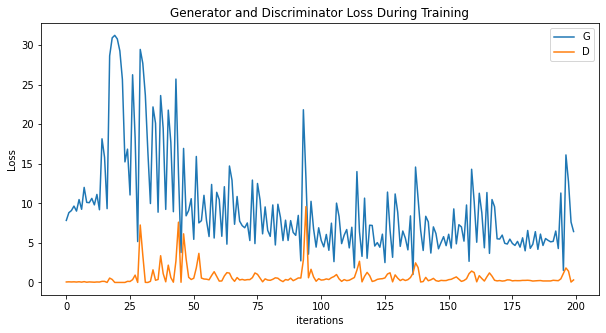

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

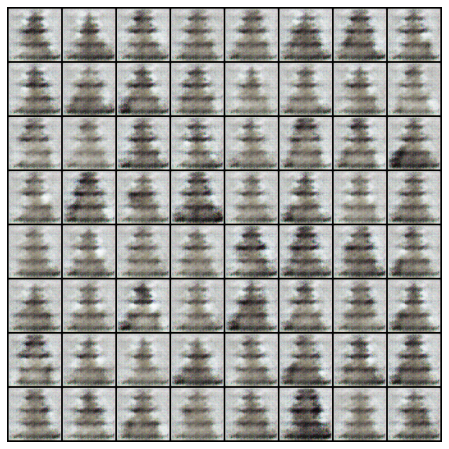

In [19]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())